In [2]:
import os
import matplotlib.pyplot as plt
import skimage
import numpy as np
from scipy import ndimage as ndi
from skimage import io
import pandas as pd
import scipy
import cv2

In [3]:
dados = pd.DataFrame()
# importa nome dos ficheiros
lista = []
for file in os.listdir('photos/bios'):
    lista.append(file)
dados['file'] = lista
# extrai atributos dos ficheiros com base nos nomes
res = []
for name in dados['file']:
    res.append(name.split('-'))

dados['Lt'] = [item[5] for item in res]
dados['Lt'] = dados['Lt'].apply(lambda x: float(x.split()[0].replace(',','.')))
dados['month'] = [item[3][2:5] for item in res]
dados['semester'] = ['S1' if month in ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun'] else 'S2' for month in dados['month']]
# prepara idades
dados['age'] = 0
#limpeza
del lista, res

In [4]:
teste_01 = io.imread('photos/bios/GUU-Draco-Amo9-29Mai70-515-29,1-2-0,5-DIR.jpg')
teste_02 = io.imread('photos/bios/GUU-Mar Roxo-Amo4-27Fev08-202-23,4-2,5-0,5-ESQ.jpg')
teste_03 = io.imread('photos/AM3 CL_20112018/CL19_20112018.jpg')
teste_04 = io.imread('photos/NOVAS FOTOS/0004.tif', plugin='pil')
teste_05 = io.imread('photos/bios/GUU-Deneb-Amo2-21Jan08-49-20,9-2-0,5.jpg')

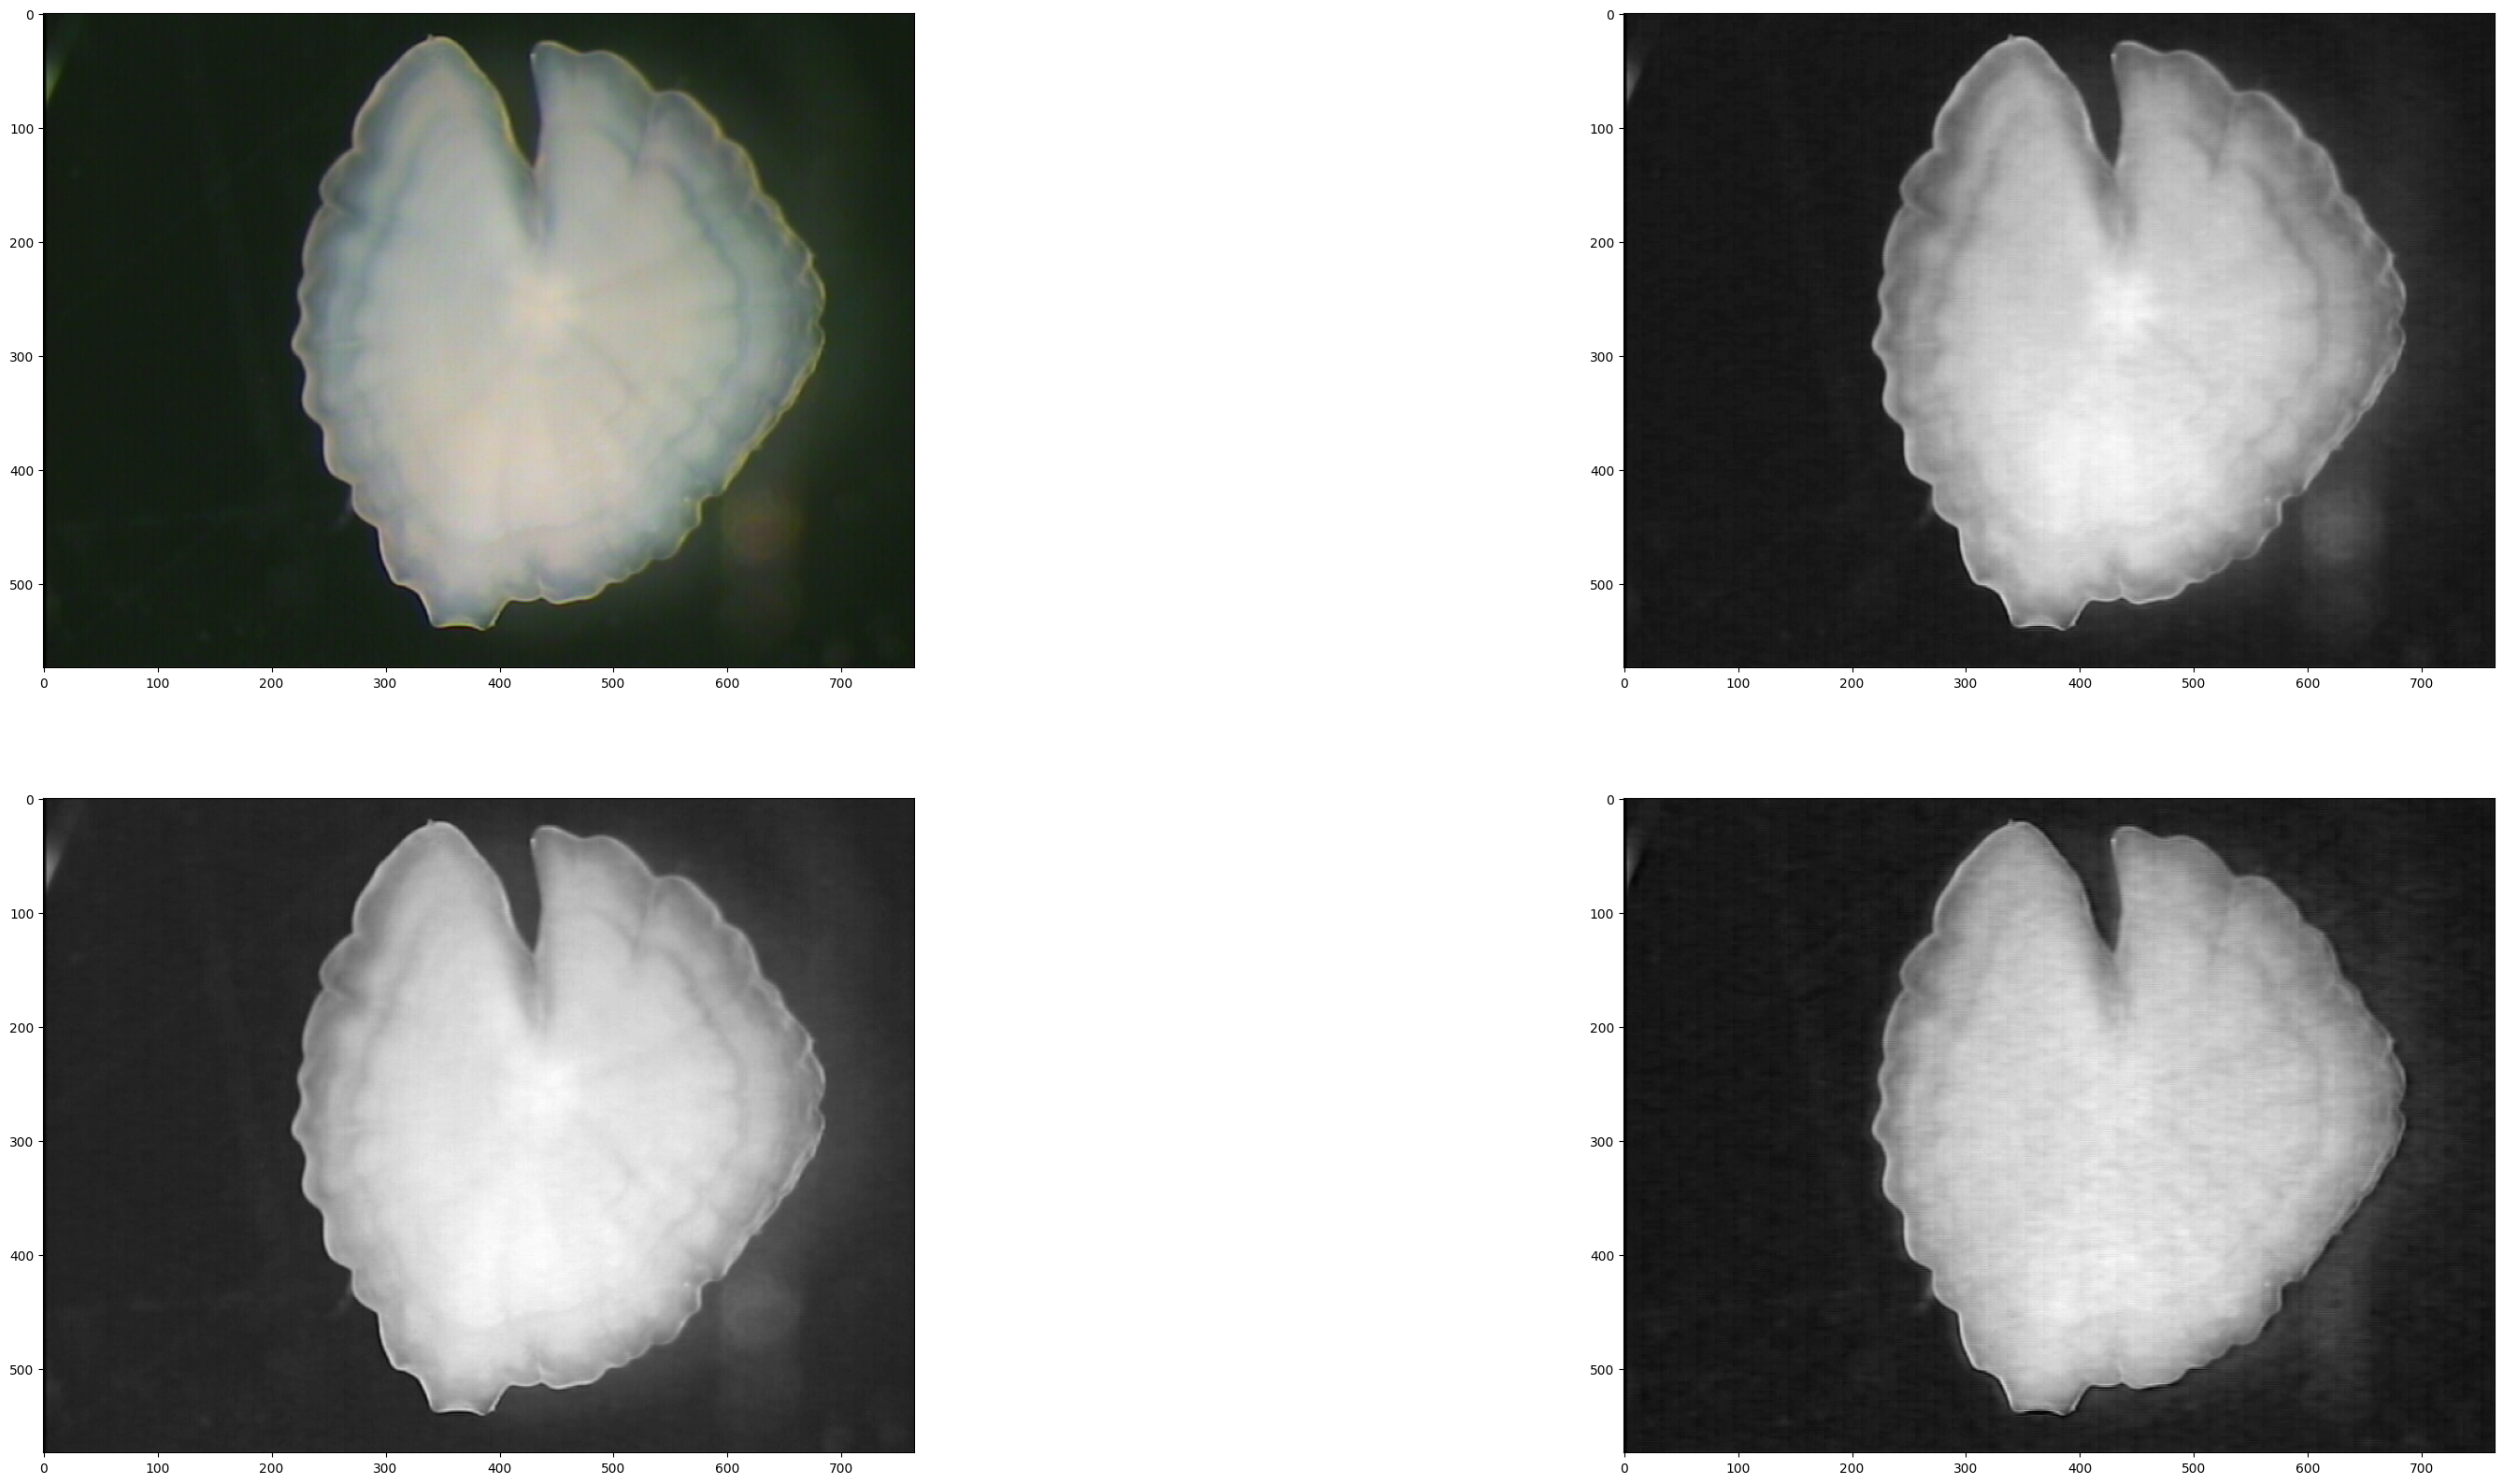

In [5]:
img = io.imread(('photos/bios/'+dados['file'][300]))
f, ax = plt.subplots(2,2, figsize = (40,20))
ax[0,0].imshow(img)
ax[0,1].imshow(img[:,:,0], cmap = plt.cm.gray)
ax[1,0].imshow(img[:,:,1], cmap = plt.cm.gray)
ax[1,1].imshow(img[:,:,2], cmap = plt.cm.gray)

# Função: Prototipo 1:

In [15]:
def suavizador(perfil:list, h=3):
    res = np.convolve(perfil, np.ones(h), "valid")/h
    return res

def deriv(perfil: list, ordem: int = 1):
    res = []
    if ordem == 1:
        for i in range(ordem, np.shape(perfil)[0] - ordem):
            res.append((perfil[i + ordem] - perfil[i - ordem]) / 2*ordem)
    else:
        for i in range(ordem, np.shape(perfil)[0] - ordem):
            res_n = 0
            for j in range(1, ordem+1):
                res_n += (perfil[i + j] - perfil[i - j])
            res.append(res_n/(2*ordem))
    return res

def conta_transicoes(trans:list):
    trans_b = []
    dist = []
    for i in range(1, np.shape(trans)[0]-1):
        if trans[i+1] > 0 and trans[i] < 0:
            trans_b.append('H-O')
            dist.append(i)
        elif trans[i+1] < 0 and trans[i] > 0:
            trans_b.append('O-H')
    trans_limpo = [item for item in trans_b if item == 'H->0']
    # bordo
    bordo = trans_b[-1]
    return trans_limpo, dist, bordo

def drop_falsos(lista:list, lista_valid):
    k = 0
    for i, j in zip(lista, lista[1:]):
        if i < j:
            lista_valid[k] = 0
        k += 1
    return lista_valid

def drop_falsos_reverse(lista:list, lista_valid):
    k = 0
    for i, j in zip(lista, lista[1:]):
        if i < j:
            lista_valid[k+1] = 0
        k += 1
    return lista_valid

def distanciador(lista: list):
    res = [lista[indice + 1] - lista[indice] for indice in range(len(lista) - 1)]
    return res

In [25]:
def processador(imagem,
                plot:bool=True,
                plot_aneis:bool = False,
                semester = 'S1',
                kernel:int = 101,
                outward:bool = True,
                smooth:int = 3,
                perf_deriv:int =1,
                layer:str = "raw",
                perfil:str = 'raw'):

    if layer == 'raw':
        colapsado = skimage.color.rgb2gray(imagem)
    elif layer == 'red':
        colapsado = imagem[:,:,0]/255

    # prepara histograma para desenhar imagem
    histogram, bin_edges = np.histogram(colapsado, bins=100, range=(0, 1))

    # detecta a borda e cria uma mascara
    markers = np.zeros_like(colapsado)
    markers[colapsado < 0.1] = 1 # como determinar este valor?
    markers[colapsado> 0.8] = 2 # como determinar este valor?

    edge = skimage.filters.sobel(colapsado)
    segmentation_edge = skimage.segmentation.watershed(edge, markers)

        # identifica o objecto maior
    otolito = skimage.filters.apply_hysteresis_threshold(colapsado*segmentation_edge, high = 0.6, low = 0.4) # validar valores
    labeled = ndi.label(otolito)[0]

    # identifica o centroide
    largest_nonzero_label = np.argmax(np.bincount(labeled[labeled > 0]))
    binary = labeled == largest_nonzero_label
    skeleton = skimage.morphology.skeletonize(binary)
    g, nodes = skimage.graph.pixel_graph(skeleton, connectivity=2)
    px, distances = skimage.graph.central_pixel(
    g, nodes=nodes, shape=skeleton.shape, partition_size=100)

    centroid = skimage.measure.centroid(labeled > 0)

    # identifica a borda pixel a pixel
    borda = skimage.measure.find_contours(binary) # em vez de segmentation edge?

    # calcula extremo do rostro
    origin_x, origin_y = px[1], px[0]
    res = []
    for array in borda:
        for line in array:
            res.append(line.tolist())

    distancia = []
    for item in res:
        distancia.append(np.sqrt((origin_y-item[1])**2 + (origin_x-item[0])**2))
    max_index = distancia.index(max(distancia))
    extremo = res[max_index]
    origin = [origin_x, extremo[1]]
    dest = [origin_y,extremo[0]]

    # Versao smoothed da imagem
    hpf = colapsado - cv2.GaussianBlur(colapsado,(kernel,kernel),0)

    # linha de perfil a partir do centroide - pode ser feita a partir do colapsado ou do hpf
    profile = skimage.measure.profile_line(colapsado, src = (origin_y, origin_x), dst = (extremo[0],extremo[1]))
    profile_hpf = skimage.measure.profile_line(hpf, src = (origin_y, origin_x), dst = (extremo[0],extremo[1]))

    # histograma do perfil; intuiçao para smoothing
    p_hist, p_bin = np.histogram(profile, bins=255, range=(0, 1))

    #contagem de aneis
    if perfil == 'raw':
        smoothed = suavizador(profile, smooth)
    else:
        smoothed = suavizador(profile_hpf, smooth)

    smoothed_deriv = deriv(smoothed, ordem= perf_deriv)

    _,transicoes,bordo = conta_transicoes(smoothed_deriv)

    # começa aqui a nova funcao
    valid = np.ones_like(transicoes)
    transicoes_validas = transicoes.copy()
    print(transicoes_validas)

    contador = 0
    while contador <= len(transicoes):
        diff = distanciador(transicoes_validas)
        #print(f'diff = {diff}')
        if outward:
            valid = drop_falsos(diff, valid)
        else:
            valid = drop_falsos_reverse(diff, valid)
        transicoes_validas = [transicoes_validas[i] * valid[i] for i in range(len(transicoes_validas))]
        transicoes_validas = [i for i in transicoes_validas if i != 0]
        valid = np.ones_like(transicoes_validas)
        #print(transicoes_validas)
        contador += 1

    if bordo == 'O-H' and semester == 'S1':
        bordo = 1
    else:
        bordo = 0

    age = 0
    for i in transicoes_validas:
        if i != 0:
            age +=1
    age += bordo

    # visualização de alguns picos
    picos = scipy.signal.find_peaks(smoothed, prominence = 0.012) # manipular distance e width
    vales = scipy.signal.find_peaks(smoothed*-1, prominence = 0.012)

    # plots
    if plot:
        f, ax = plt.subplots(3,3, figsize = (40,20))
        # imagem original em grayscale
        ax[0,0].imshow(colapsado, cmap = plt.cm.gray)
        # imagem original depois de retirar o fundo por watershed
        ax[0,1].imshow(colapsado * mascara, cmap = plt.cm.gray)
        # histograma da imagem original
        ax[0,2].plot(bin_edges[0:-1], histogram)
        # regiao do otolito determinada por hysteresis
        ax[1,0].imshow(otolito, cmap = plt.cm.gray)
        # centroide, borda e linha de perfil do otolito

        #ax[1,1].imshow(skimage.color.label2rgb(skeleton, colapsado*mascara)) # versao original com mascara
        ax[1,1].imshow(colapsado, cmap = plt.cm.gray)
        ax[1,1].plot(origin, dest, linewidth = 5, color = 'r')
        ax[1,1].scatter(px[1], px[0], label='graph center')
        ax[1,1].scatter(centroid[1], centroid[0], label='centroid')
        ax[1,1].legend()
        ax[1,1].set_axis_off()
        ax[1,1].set_title('graph center vs centroid')
        for contour in borda:
            ax[1,1].plot(contour[:, 1], contour[:, 0], linewidth=4, color = 'r')

        # perfil desenhado do otolito
        ax[1,2].plot(profile)
        # histograma do perfil
        #ax[2,0].plot(p_bin[0:-1], p_hist)

        ax[2,1].imshow(hpf, cmap = plt.cm.gray)
        ax[2,1].plot(origin, dest, linewidth = 5, color = 'r')
        ax[2,1].scatter(px[1], px[0], label='graph center')
        ax[2,1].scatter(centroid[1], centroid[0], label='centroid')
        ax[2,1].legend()
        ax[2,1].set_axis_off()
        ax[2,1].set_title('graph center vs centroid')
        for contour in borda:
            ax[2,1].plot(contour[:, 1], contour[:, 0], linewidth=4, color = 'r')

        ax[2,2].plot(profile_hpf)
        # histograma do perfil
        #ax[2,0].plot(p_bin[0:-1], p_hist)

        ax[2,0].plot(smoothed)
        for pico in picos[0]:
            ax[2,0].vlines(x = pico, ymin = smoothed.min(), ymax= smoothed.max(), color = 'r')
        for vale in vales[0]:
            ax[2,0].vlines(x = vale, ymin = smoothed.min(), ymax= smoothed.max(), color = 'g')

    if plot_aneis:

        fig, ax = plt.subplots()
        if perfil == 'raw':
            ax.imshow(colapsado, cmap = plt.cm.gray)
        else:
            ax.imshow(hpf, cmap = plt.cm.gray)
        ax.plot(origin, dest, linewidth = 5, color = 'r')
        ax.scatter(px[1], px[0], label='graph center')
        #ax.scatter(centroid[1], centroid[0], label='centroid')
        #ax.legend()
        #plt.set_axis_off()
        #plt.set_title('graph center vs centroid')
        for contour in borda:
            ax.plot(contour[:, 1], contour[:, 0], linewidth=4, color = 'r')
        dist = 0
        for anel in transicoes:
            dist = anel
            circulo = plt.Circle((px[1], px[0]), radius=dist, color='yellow', fill = False)
            ax.add_patch(circulo)
        dist = 0
        for anel in transicoes_validas:
            dist = anel
            circulo = plt.Circle((px[1], px[0]), radius=dist, color='green', fill = False)
            ax.add_patch(circulo)

    print(f'idade estimada é {age} e o bordo é {bordo}')
    return age

[3, 20, 26, 36, 42, 46, 52, 59, 65, 71, 77, 95, 100, 107, 114, 133, 166, 186]
idade estimada é 7 e o bordo é 1


7

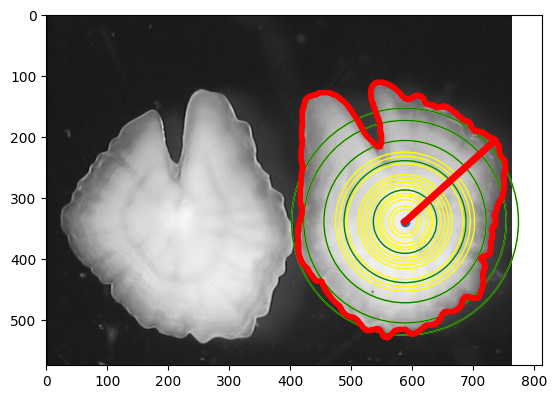

In [27]:
processador(io.imread(('photos/bios/'+dados['file'][100])), plot = False, plot_aneis=True, perf_deriv=1, outward=True)

https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.html
http://olgahernand.free.fr/gallery_scripts/html/figure_python/von_Bertalanffy_plots.html

# ensaio de contagem de aneis

In [42]:
leituras = []
for line in range(dados.shape[0]):
#for line in range(100):
    idade = processador(io.imread(('photos/bios/'+dados['file'][line])), False,
                        kernel = 151, smooth=7, layer = 'red', perfil = 'raw')
    leituras.append(idade)

[17, 36, 61, 71, 112, 142, 196]
idade estimada é 4 e o bordo é 1
[11, 16, 23, 35, 57, 84, 103, 118, 144, 158, 212, 273]
idade estimada é 4 e o bordo é 1
[28, 38, 46, 60, 94, 123, 125, 145, 156, 176, 197, 207, 243, 250, 274, 295, 334, 400]
idade estimada é 5 e o bordo é 1
[34, 48, 52, 72, 75, 104, 140, 163, 167, 196, 236, 257, 269, 289, 358, 407]
idade estimada é 5 e o bordo é 1
[2, 14, 18, 41, 45, 57, 67, 109, 120, 140, 180, 213]
idade estimada é 5 e o bordo é 1
[9, 18, 21, 42, 54, 77, 92, 138, 155]
idade estimada é 4 e o bordo é 1
[15, 49, 66, 76, 86, 106, 118, 132, 148, 163, 181, 199, 223]
idade estimada é 5 e o bordo é 1
[1, 3, 45, 58, 67, 150, 157]
idade estimada é 4 e o bordo é 1
[23, 35, 39, 44, 48, 82, 123, 147, 157]
idade estimada é 6 e o bordo é 1
[3, 17, 35, 51, 61, 107]
idade estimada é 2 e o bordo é 0
[13, 18, 22, 43, 90, 179, 197]
idade estimada é 4 e o bordo é 1
[7, 45, 86, 163, 182, 202]
idade estimada é 4 e o bordo é 1
[46, 74, 78, 88, 125, 144, 148, 158, 188]
idade est

Validaçao e modelo de crescimento

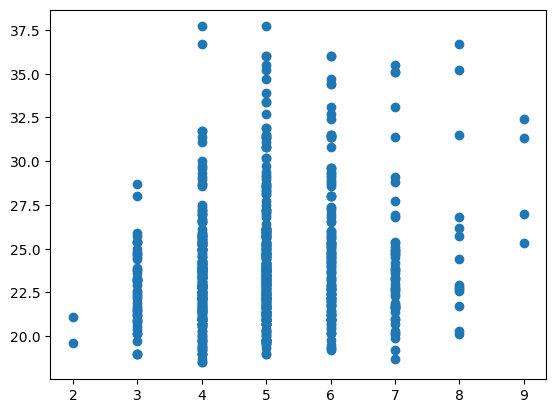

In [43]:
dados['age'] = leituras
#plt.scatter(dados['age'][0:100], dados['Lt'][0:100])
plt.scatter(dados['age'], dados['Lt'])

In [44]:
dados.to_csv('leituras.csv')

[17, 36, 61, 71, 112, 142, 196]
idade estimada é 3 e o bordo é 1
[11, 16, 23, 35, 57, 84, 103, 118, 144, 158, 212, 273]
idade estimada é 3 e o bordo é 1
[28, 38, 46, 60, 94, 123, 125, 145, 156, 176, 197, 207, 243, 250, 274, 295, 334, 400]
idade estimada é 3 e o bordo é 1
[34, 48, 52, 72, 75, 104, 140, 163, 167, 196, 236, 257, 269, 289, 358, 407]
idade estimada é 4 e o bordo é 1
[2, 14, 18, 41, 45, 57, 67, 109, 120, 140, 180, 213]
idade estimada é 4 e o bordo é 1
[9, 18, 21, 42, 54, 77, 92, 138, 155]
idade estimada é 4 e o bordo é 1
[15, 49, 66, 76, 86, 106, 118, 132, 148, 163, 181, 199, 223]
idade estimada é 4 e o bordo é 1
[1, 3, 45, 58, 67, 150, 157]
idade estimada é 4 e o bordo é 1
[23, 35, 39, 44, 48, 82, 123, 147, 157]
idade estimada é 5 e o bordo é 1
[3, 17, 35, 51, 61, 107]
idade estimada é 2 e o bordo é 0
[13, 18, 22, 43, 90, 179, 197]
idade estimada é 4 e o bordo é 1
[7, 45, 86, 163, 182, 202]
idade estimada é 4 e o bordo é 1
[46, 74, 78, 88, 125, 144, 148, 158, 188]
idade est

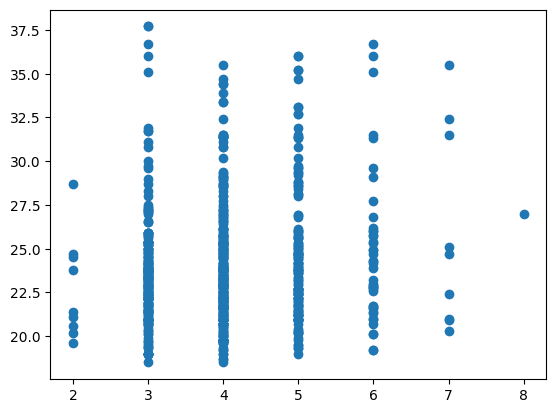

In [24]:
leituras_rev = []
for line in range(dados.shape[0]):
#for line in range(100):
    idade = processador(io.imread(('photos/bios/'+dados['file'][line])), False,
                        kernel = 151, smooth=7, layer = 'red', perfil = 'raw', outward=False)
    leituras_rev.append(idade)

dados['age'] = leituras_rev
#plt.scatter(dados['age'][0:100], dados['Lt'][0:100])
plt.scatter(dados['age'], dados['Lt'])

dados.to_csv('leituras_rev.csv')